# Pre-Processing, Modeling, EDA & Data Visualization

### Pre-Processing

In [1]:
# Imports for pre-processing
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Imports for modeling
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers.normalization import BatchNormalization

# Imports for data visualization
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix

# Imports for ResNet50
from keras.applications.resnet50 import ResNet50
from keras.layers import Dropout
from keras.models import Model
from keras import optimizers

# For reproducibility
np.random.seed(42)

# Visualization style
plt.style.use('ggplot')

In [2]:
# Create a list for each food class
burgers_list = []
hotdogs_list = []
pizza_list = []
tacos_list = []
sushi_list = []

# Create a list of all food class lists
class_list = [burgers_list, hotdogs_list, pizza_list, tacos_list, sushi_list]

# Create a list of strings containing the food classes
food_classes = ['burgers', 'hotdogs', 'pizza', 'tacos', 'sushi']

In [3]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.04-lesson-cnns/blob/master/solution-code/02-cnn.ipynb
# Define a function that converts all images
def image_converter(food_list, food_class):
    food_path = f'../images/{food_class}/'
    for file in os.listdir(food_path):
        try:
            image = load_img(food_path + file, target_size=(224, 224))
            image_arr = img_to_array(image) / 255
            food_list.append(image_arr)
        except:
            print(f'Error for file: {file}')
    print(f'{len(food_list)} pictures have been converted for {food_class}.')

**Note:** The target size of the image is the first hyperparameter. A multiple of 32 usually works well. Target sizes I considered and tested include: 224x224, 256x256, 384x384, and 512x512.

In [4]:
# Iterate through the image_converter function for each food class
my_index = 0
for food_class in class_list:
    image_converter(food_class, food_classes[my_index])
    my_index += 1

Error for file: .DS_Store
282 pictures have been converted for burgers.
Error for file: .DS_Store
253 pictures have been converted for hotdogs.
Error for file: .DS_Store
276 pictures have been converted for pizza.
Error for file: .DS_Store
260 pictures have been converted for tacos.
Error for file: .DS_Store
268 pictures have been converted for sushi.


### Modeling

#### Null Model

In [5]:
# Baseline accuracy of the majority class
282/(282+253+276+260+268)

0.210604929051531

**Interpretation:** The baseline accuracy of the majority class (i.e. burgers) is 21.06%. At a minimum, the production model must have an accuracy score that exceeds that of the null model.

#### Model 1: Simple CNN made from scratch

In [6]:
# Define X
X = burgers_list + hotdogs_list + pizza_list + tacos_list + sushi_list
X = np.array(X)
print(f'X shape: {X.shape}')

# Define y
# 0 for burgers, 1 for hotdogs, 2 for pizza, 3 for tacos, 4 for sushi
y = [0]*282 + [1]*253 + [2]*276 + [3]*260 + [4]*268
y = np.array(y)
y = to_categorical(y)
print(f'y shape: {y.shape}')

X shape: (1339, 224, 224, 3)
y shape: (1339, 5)


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [8]:
# Reshape
X_train = np.array(X_train)
X_test = np.array(X_test)

# Check shape
print(f'X train shape: {X_train[0].shape}')
print(f'y train shape: {y_train.shape}')

X train shape: (224, 224, 3)
y train shape: (1004, 5)


In [9]:
# Referenced: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Referenced: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# Image data augmentation

aug = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    shear_range=0.15
)

**Notes:** All of the arguments set in the ImageDataGenerator are hyperparameters.
- width_shift_range and height_shift_range: control the amount of horizontal and vertical shift, respectively
- horizontal_flip: reverses the columns of pixels
- rotation_range: rotates the image clockwise by a given number of degrees
- zoom_range: 1.0 has no effect on zoom. >1.0 zooms out (interpolates pixels), <1.0 zooms in (adds new pixels)
- shear_range: shear intensity

In [10]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.04-lesson-cnns/blob/master/solution-code/02-cnn.ipynb
# Model architecture
cnn1 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(X_train[0].shape)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation='relu'),
    Dense(units=5, activation='softmax')
])

# Compile the cnn1
cnn1.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 'Recall', 'Precision'])

# Fit the model
results = cnn1.fit(aug.flow(X_train, y_train, batch_size=8), 
                    validation_data=(X_test, y_test),
                    batch_size=8, epochs=20)

Epoch 1/20
126/126 [==============================] - 111s 860ms/step - loss: 2.9441 - accuracy: 0.2181 - recall: 0.0082 - precision: 0.0894 - val_loss: 1.6062 - val_accuracy: 0.2000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
126/126 [==============================] - 92s 725ms/step - loss: 1.6006 - accuracy: 0.2255 - recall: 0.0015 - precision: 0.3304 - val_loss: 1.5731 - val_accuracy: 0.2567 - val_recall: 0.0388 - val_precision: 0.5000
Epoch 3/20
126/126 [==============================] - 96s 765ms/step - loss: 1.5855 - accuracy: 0.2841 - recall: 0.0104 - precision: 0.3275 - val_loss: 1.5789 - val_accuracy: 0.3045 - val_recall: 0.0597 - val_precision: 0.5263
Epoch 4/20
126/126 [==============================] - 91s 721ms/step - loss: 1.5357 - accuracy: 0.3174 - recall: 0.0415 - precision: 0.6349 - val_loss: 1.5671 - val_accuracy: 0.2657 - val_recall: 0.0448 - val_precision: 0.7895
Epoch 5/20
126/126 [==============================] - 96s 757ms/step - loss: 1.5391

**Interpretation:** The architecture of the convolutional neural network above is quite simple. The model contains an input layer, two convolutional layers, two pooling layers, a fully connected/dense layer, and a softmax layer that returns the output. Despite its simplicity, the model achieved an accuracy of 42.69% on unseen data, which exceeds that of the null model. CNNs involve lots of hyperparameters that can be tuned via Hyperas. However, tuning the hyperparameters of a CNN is one of the most computationally expensive tasks that can be done. Given the time and budgetary limitations of this project, I will not attempt to tune the hyperparameters for an optimal combination.

In [12]:
# Check model summary
cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11944000  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

### EDA & Data Visualization

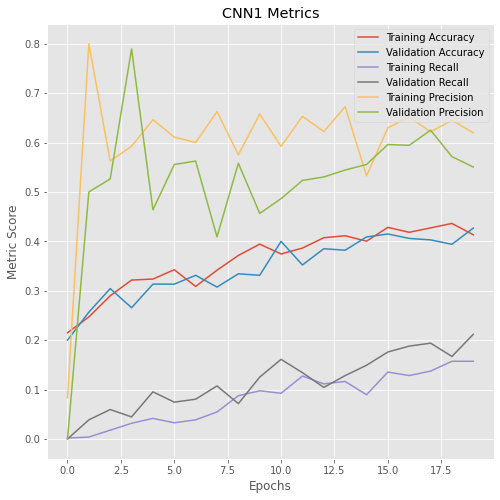

In [13]:
# Plot accuracy, recall, and precision
plt.figure(figsize=(8,8))

plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')

plt.plot(results.history['recall'], label='Training Recall')
plt.plot(results.history['val_recall'], label='Validation Recall')

plt.plot(results.history['precision'], label='Training Precision')
plt.plot(results.history['val_precision'], label='Validation Precision')

plt.title('CNN1 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** The 3 main metrics for this project include: accuracy, recall, and precision. These metrics have been plotted over numerous epochs.

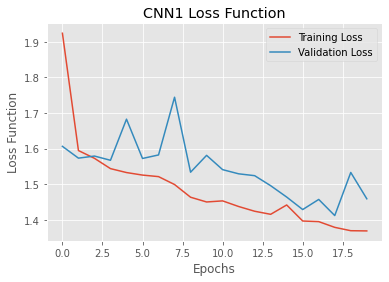

In [14]:
# Plot loss function
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')

plt.title('CNN1 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above. The ideal value for a loss function is 0.

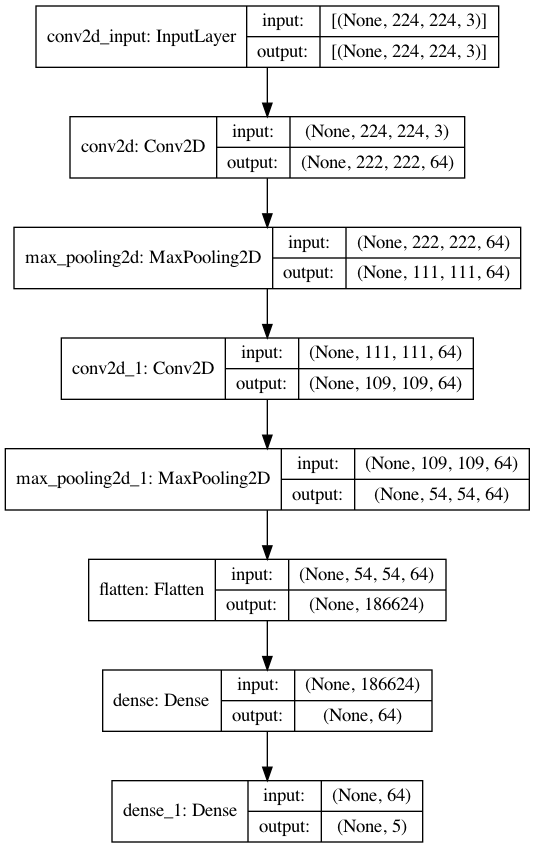

In [15]:
# Referenced: https://git.generalassemb.ly/DSIR-Lancelot/8.02-lesson-tensorflow-keras/blob/master/starter-code-Adi-InClass.ipynb
# Visualize model layers
plot_model(cnn1, show_layer_names=True, show_shapes=True)

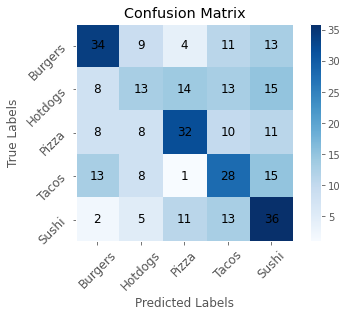

In [16]:
# Referenced: https://github.com/clairehester/face-mask-detector/blob/main/code/02_face_mask_detector.ipynb
# Plot multiclass confusion matrix
preds = cnn1.predict(X_test, batch_size=8)
preds = np.argmax(preds, axis=1)

cm = confusion_matrix(y_test.argmax(axis=1), preds)
plt.imshow(cm, cmap='Blues', interpolation='nearest')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.grid(None)
plt.colorbar()

for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', size='large')

plt.show()

**Interpretation:** A multiclass confusion matrix has been plotted above.

#### Model 2: CNN with more layers

In [17]:
# Referenced: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
# Model architecture
cnn2 = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
           padding='same', input_shape=(X_train[0].shape)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu',
          padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(5, activation='softmax')
])

# Compile the model
cnn2.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 'Recall', 'Precision'])

# Fit the model
results2 = cnn2.fit(aug.flow(X_train, y_train, batch_size=8), 
                    validation_data=(X_test, y_test), 
                    batch_size=8, epochs=20)

Epoch 1/20
126/126 [==============================] - 200s 2s/step - loss: 2.4438 - accuracy: 0.2453 - recall: 0.1605 - precision: 0.2520 - val_loss: 2.0830 - val_accuracy: 0.2537 - val_recall: 0.1403 - val_precision: 0.2686
Epoch 2/20
126/126 [==============================] - 196s 2s/step - loss: 1.6673 - accuracy: 0.3256 - recall: 0.1782 - precision: 0.4008 - val_loss: 1.8187 - val_accuracy: 0.2746 - val_recall: 0.1433 - val_precision: 0.3038
Epoch 3/20
126/126 [==============================] - 196s 2s/step - loss: 1.5454 - accuracy: 0.3786 - recall: 0.1912 - precision: 0.4777 - val_loss: 3.1138 - val_accuracy: 0.2597 - val_recall: 0.2299 - val_precision: 0.2770
Epoch 4/20
126/126 [==============================] - 197s 2s/step - loss: 1.4240 - accuracy: 0.4265 - recall: 0.2458 - precision: 0.5376 - val_loss: 3.8458 - val_accuracy: 0.2507 - val_recall: 0.2179 - val_precision: 0.2570
Epoch 5/20
126/126 [==============================] - 196s 2s/step - loss: 1.5089 - accuracy: 0.3480

**Interpretation:** Model 2 has an accuracy of 54.93% on unseen data.

In [19]:
# Check model summary
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 64)     

### EDA & Data Visualization

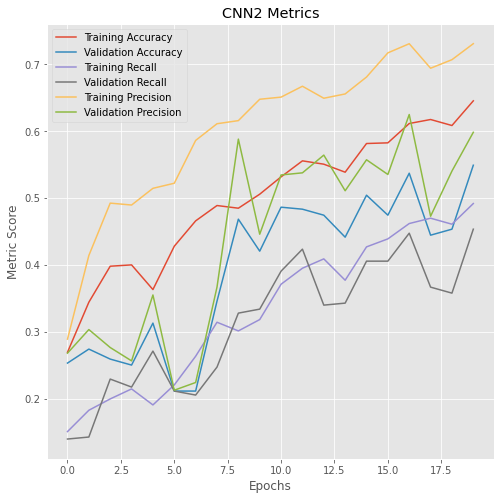

In [20]:
# Plot accuracy, recall, and precision
plt.figure(figsize=(8,8))

plt.plot(results2.history['accuracy'], label='Training Accuracy')
plt.plot(results2.history['val_accuracy'], label='Validation Accuracy')

plt.plot(results2.history['recall'], label='Training Recall')
plt.plot(results2.history['val_recall'], label='Validation Recall')

plt.plot(results2.history['precision'], label='Training Precision')
plt.plot(results2.history['val_precision'], label='Validation Precision')

plt.title('CNN2 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** Accuracy, recall, and precision have been plotted over numerous epochs.

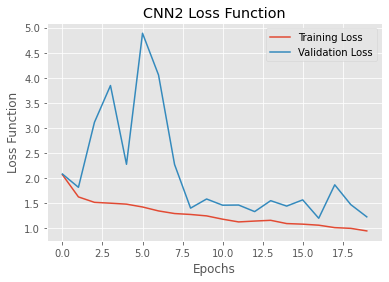

In [21]:
# Plot loss function
plt.plot(results2.history['loss'], label='Training Loss')
plt.plot(results2.history['val_loss'], label='Validation Loss')

plt.title('CNN2 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above.

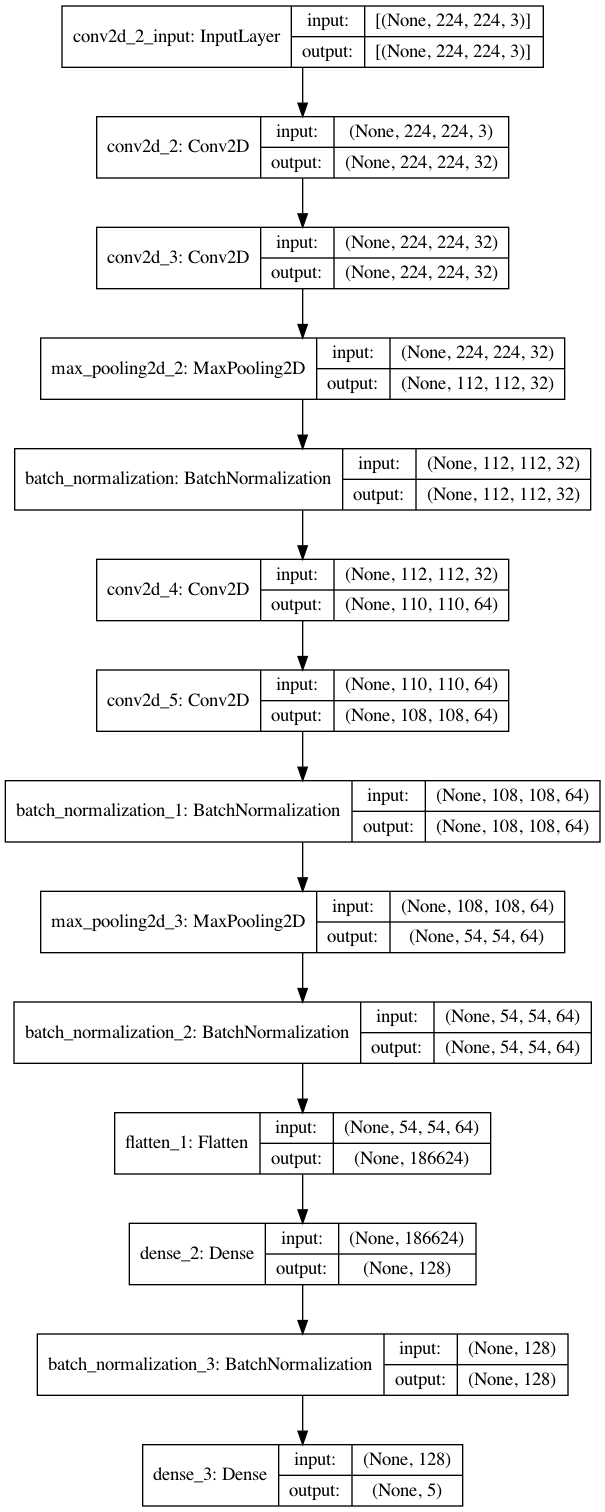

In [22]:
# Visualize model layers
plot_model(cnn2, show_layer_names=True, show_shapes=True)

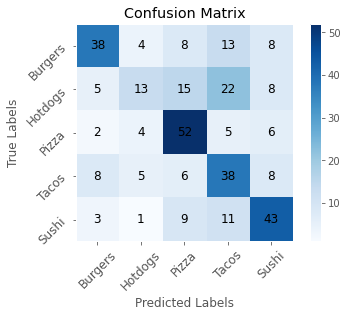

In [23]:
# Plot multiclass confusion matrix
preds2 = cnn2.predict(X_test, batch_size=8)
preds2 = np.argmax(preds2, axis=1)

cm2 = confusion_matrix(y_test.argmax(axis=1), preds2)
plt.imshow(cm2, cmap='Blues', interpolation='nearest')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm2)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm2)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.grid(None)
plt.colorbar()

for i in range(len(cm2)):
    for j in range(len(cm2)):
        plt.text(j, i, cm2[i, j], ha='center', va='center', size='large')

plt.show()

**Interpretation:** A multiclass confusion matrix has been plotted above.

#### Model 3: Transfer Learning with ResNet50

In [24]:
# Referenced: https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
# Image data augmentation
train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   zoom_range=0.15,
                                   shear_range=0.15) 
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_test, y_test, batch_size=8)

In [25]:
# Model architecture
resnet = ResNet50(include_top=False, weights='imagenet',
                  input_shape=X_train[0].shape)

output = resnet.layers[-1].output
output = Flatten()(output)

resnet = Model(inputs=resnet.input, outputs=output)

for layer in resnet.layers:
    layer.trainable = False
    
cnn3 = Sequential([
    resnet,
    Dense(units=64, activation='relu', input_dim=X_train[0].shape),
    Dropout(rate=0.2),
    Dense(units=64, activation='relu'),
    Dropout(rate=0.2),
    Dense(units=5, activation='softmax')
])

cnn3.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision'])

results3 = cnn3.fit_generator(generator=train_generator, 
                              validation_data=val_generator,
                              epochs=20)

# results3 = cnn3.fit(X_train, y_train,
#                    validation_data=(X_test, y_test),
#                    batch_size=8, epochs=20)

/Users/seungwoochoi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
126/126 [==============================] - 172s 1s/step - loss: 1.6688 - accuracy: 0.2011 - recall: 0.0044 - precision: 0.2026 - val_loss: 1.5964 - val_accuracy: 0.2955 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
126/126 [==============================] - 164s 1s/step - loss: 1.6101 - accuracy: 0.2224 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5943 - val_accuracy: 0.2955 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/20
126/126 [==============================] - 164s 1s/step - loss: 1.6043 - accuracy: 0.2151 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5971 - val_accuracy: 0.2955 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/20
126/126 [==============================] - 164s 1s/step - loss: 1.6026 - accuracy: 0.2400 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 1.5884 - val_accuracy: 0.2687 - val_recall: 0.0030 - val_precision: 1.0000
Epoch 5/20
126/126 [==============================] 

**Interpretation:** Model 3 has an accuracy of 30.15% on unseen data.

In [27]:
# Check model summary
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 30,014,789
Trainable params: 6,427,077
Non-trainable params: 23,587,712
__________________________________

### EDA & Data Visualization

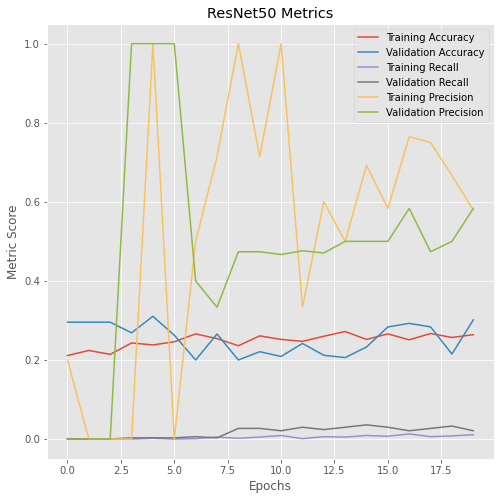

In [28]:
# Plot accuracy, recall, and precision
plt.figure(figsize=(8,8))

plt.plot(results3.history['accuracy'], label='Training Accuracy')
plt.plot(results3.history['val_accuracy'], label='Validation Accuracy')

plt.plot(results3.history['recall'], label='Training Recall')
plt.plot(results3.history['val_recall'], label='Validation Recall')

plt.plot(results3.history['precision'], label='Training Precision')
plt.plot(results3.history['val_precision'], label='Validation Precision')

plt.title('ResNet50 Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.legend();

**Interpretation:** Accuracy, recall, and precision have been plotted over numerous epochs.

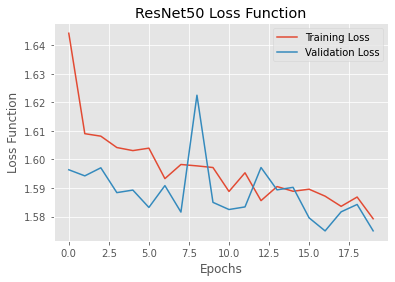

In [29]:
# Plot loss function
plt.plot(results3.history['loss'], label='Training Loss')
plt.plot(results3.history['val_loss'], label='Validation Loss')

plt.title('ResNet50 Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend();

**Interpretation:** The loss function is plotted above.

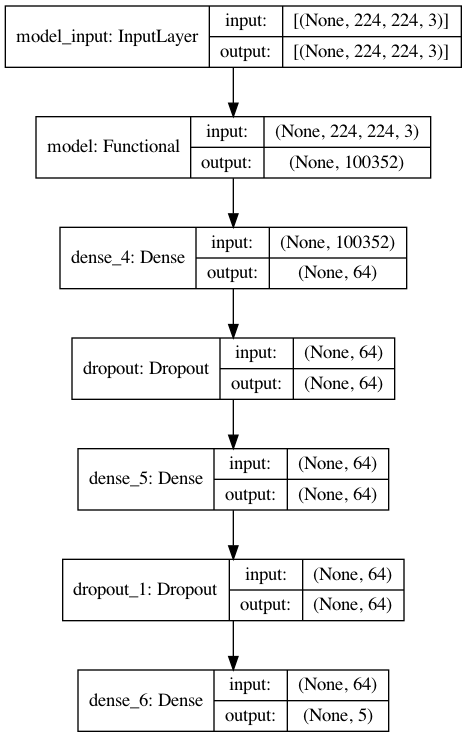

In [30]:
# Visualize model layers
plot_model(cnn3, show_layer_names=True, show_shapes=True)

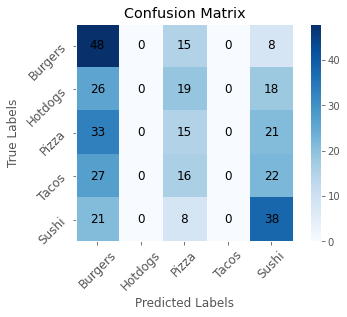

In [31]:
# Plot multiclass confusion matrix
preds3 = cnn3.predict(X_test, batch_size=8)
preds3 = np.argmax(preds3, axis=1)

cm3 = confusion_matrix(y_test.argmax(axis=1), preds3)
plt.imshow(cm3, cmap='Blues', interpolation='nearest')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(len(cm3)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.yticks(np.arange(len(cm3)), ['Burgers', 'Hotdogs', 'Pizza', 'Tacos', 'Sushi'], rotation=45, size='large')
plt.grid(None)
plt.colorbar()

for i in range(len(cm3)):
    for j in range(len(cm3)):
        plt.text(j, i, cm3[i, j], ha='center', va='center', size='large')

plt.show()

**Interpretation:** A multiclass confusion matrix has been plotted above. In 20 epochs, ResNet50 did not learn how to predict hotdogs and tacos.

### Production Model
Model 2 is my choice for the production model. While recall and precision are important classification metrics, accuracy is the most relevant to the problem statement in this project, which involves predicting the correct food class for each image. The baseline accuracy I sought to beat is 21.06% since burgers constitute the majority class. After 20 epochs, Model 1 achieved a validation accuracy of 42.69%, Model 2 attained 54.93%, and Model 3 reached 30.15%. Since the predictive capability of the model is key to the objective, Model 2 is the most suitable to be the production model.

### Executive Summary
Using fewer than 300 images per class, my production model achieved an accuracy of 54.93% on unseen data for a multiclass image classification problem. Altogether, the convolutional neural network made from scratch had 15 layers (including the input and output layers) and utilized image data augmentation to enhance its performance. The model performed the best when predicting pizza and performed the worst when predicting tacos when the image was actually a hotdog. I also implemented IBM's pre-trained ResNet50 model in a transfer learning environment, but the model did not achieve a higher validation accuracy than the production model in the designated 20 epochs.

#### Model 4: Transfer Learning with EfficientNet

In [42]:
# Referenced: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb#scrollTo=G2iZMMXDMEb_
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
# Classic, underfit neural network
inputs = layers.Input(shape=X_train[0].shape)
x = img_augmentation(inputs)
new_model = EfficientNetB0(include_top=False, input_tensor=x, weights='imagenet')

# new_model.trainable = False # Freeze the pretrained weights
for layer in new_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D(name='avg_pool')(new_model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name='top_dropout')(x)
outputs = layers.Dense(5, activation='softmax', name='pred')(x)

new_model = tf.keras.Model(inputs, outputs, name='EfficientNet')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
new_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

# Fit the model
new_results = new_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                   batch_size=8, epochs=3) # Change # of epochs to 50

In [27]:
img_augmentation = Sequential([
    preprocessing.RandomRotation(factor=0.15),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomFlip(),
    preprocessing.RandomContrast(factor=0.1),
    ],
    name='img_augmentation',
)

In [28]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0

In [34]:
# Attempt 2
inputs2 = layers.Input(shape=X_train[0].shape)
x2 = img_augmentation(inputs2)
new_model2 = EfficientNetB0(include_top=False, input_tensor=x2, weights='imagenet')

new_model2.trainable = False

x2 = layers.GlobalAveragePooling2D(name='avg_pool')(new_model2.output)
x2 = layers.BatchNormalization()(x2)

top_dropout_rate = 0.2
x2 = layers.Dropout(top_dropout_rate, name='top_dropout')(x2)
outputs2 = layers.Dense(5, activation='softmax', name='pred')(x2)

new_model2 = tf.keras.Model(inputs2, outputs2, name='EfficientNet')
optimizer2 = tf.keras.optimizers.Adam(learning_rate=1e-2)
new_model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

new_results2 = new_model2.fit(X_train, y_train, validation_data=(X_test, y_test),
                   batch_size=8, epochs=3)

Epoch 1/3
126/126 [==============================] - 165s 1s/step - loss: 6.5497 - accuracy: 0.2021 - val_loss: 1.6830 - val_accuracy: 0.2119
Epoch 2/3
126/126 [==============================] - 151s 1s/step - loss: 2.2781 - accuracy: 0.2026 - val_loss: 1.6798 - val_accuracy: 0.1881
Epoch 3/3
126/126 [==============================] - 168s 1s/step - loss: 2.0425 - accuracy: 0.2040 - val_loss: 1.7419 - val_accuracy: 0.2119


In [36]:
# Attempt 3
import efficientnet.keras as efn

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)
train_generator = train_datagen.flow_from_directory(X_train, batch_size = 20, class_mode='categorical', target_size = (224, 224))
validation_generator = test_datagen.flow_from_directory(X_test, batch_size = 20, class_mode='categorical', target_size = (224, 224))

base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
x = model1.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation="softmax")(x)
model_final = Model(input = model1.input, output = predictions)

model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 3)

ValueError: listdir: embedded null character in path

### Post-Modeling

In [ ]:
# Use AWS SageMaker

In [ ]:
# Classification report

In [ ]:
# Analysis of misclassifications

### Exploratory Data Analysis (EDA)

In [ ]:
# # To continue EDA on another notebook
# from tensorflow.keras.models import load_model

# cnn2 = load_model('../models/cnn2.h5')

# cnn2.summary()

In [15]:
from PIL import Image

In [16]:
# Histogram of image dimensions
im = Image.open('../images/burgers/burgers_1.jpg')
im.size[0]

3024

In [17]:
def image_size_retriever(food_list, food_class):
    image_dict = {}
    file_path = f'../images/{food_class}'
    for file in os.listdir(file_path):
        try:
            image = Image.open(file_path + file)
            image_dict[image.size[0]] = image_dict[image.size[1]]
        except:
            print(f'Error for file: {file}')
    return image_dict

In [18]:
my_index = 0
for food_class in class_list:
    image_size_retriever(food_class, food_classes[my_index])
    my_index += 1

Error for file: burgers_15.jpg
Error for file: burgers_29.jpg
Error for file: burgers_198.jpg
Error for file: burgers_239.jpg
Error for file: burgers_211.jpg
Error for file: burgers_205.jpg
Error for file: burgers_204.jpg
Error for file: burgers_210.jpg
Error for file: burgers_238.jpg
Error for file: burgers_199.jpg
Error for file: burgers_28.jpg
Error for file: burgers_14.jpg
Error for file: burgers_14.png
Error for file: burgers_16.png
Error for file: burgers_206.jpg
Error for file: burgers_212.jpg
Error for file: burgers_213.jpg
Error for file: burgers_207.jpg
Error for file: burgers_17.png
Error for file: burgers_13.png
Error for file: burgers_13.jpg
Error for file: .DS_Store
Error for file: burgers_203.jpg
Error for file: burgers_217.jpg
Error for file: burgers_216.jpg
Error for file: burgers_202.jpg
Error for file: burgers_12.jpg
Error for file: burgers_12.png
Error for file: burgers_348.jpg
Error for file: burgers_38.jpg
Error for file: burgers_10.jpg
Error for file: burgers_214

In [ ]:
def image_converter(food_list, food_class):
    food_path = f'../images/{food_class}/'
    for file in os.listdir(food_path):
        try:
            image = load_img(food_path + file, target_size=(384, 384))
            image_arr = img_to_array(image) / 255
            food_list.append(image_arr)
        except:
            print(f'Error for file: {file}')
    print(f'{len(food_list)} pictures have been converted for {food_class}.')

In [ ]:
my_index = 0
for food_class in class_list:
    image_converter(food_class, food_classes[my_index])
    my_index += 1

In [ ]:
class_list = [burgers_list, hotdogs_list, pizza_list, tacos_list, sushi_list]

In [ ]:
food_classes = ['burgers', 'hotdogs', 'pizza', 'tacos', 'sushi']